In [1]:
# import packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import torch
from numpy import argmax
from numpy import array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Data Processing

In [3]:
def clean_seq(seq):
    
    seq = pd.Series(seq)
    sequences = [seq.str.replace('[^ACGT]','N')]
    sequences = np.squeeze(sequences)
    
    for i in range(len(sequences)):
        sequences[i] = sequences[i].ljust(1058,'N')

    sequences_array = np.array(sequences)

    seq_list_padded = []
    for i in range(len(sequences_array)):
        list_seq = list(sequences_array[i])
        del list_seq[650:]
        seq_list_padded.append(list_seq)

    replace_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5}
    
    integer_encoded = []
    for i in range(len(seq_list_padded)):
        C = (pd.Series(seq_list_padded[i])).map(replace_map) #convert the list to a pandas series temporarily before mapping
        integer_encoded.append(list(C))
    
    data = np.array([1, 2, 3, 4, 5])
    data = data.reshape(-1, 1) 
    
    integer_encoded = np.array(integer_encoded).astype(int)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(data)
    
    one_hot_encoded_seqs = []
    
    for i in range(len(integer_encoded)):
        integer_encoded_tmp = integer_encoded[i].reshape(len(integer_encoded[i]), 1)
        onehot_encoded = np.array(onehot_encoder.transform(integer_encoded_tmp)).flatten()
        one_hot_encoded_seqs.append(onehot_encoded)
        
    one_hot_encoded_seqs_array = np.array(one_hot_encoded_seqs)
    
    return one_hot_encoded_seqs_array

def load_n_encode_labels(labels):
    softmax_layer = len(set(labels))
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)
    #label_seq = label_seq.reshape(len(label_seq), 1)
    
    return label_seq, le, softmax_layer

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

In [ ]:
# read data

train_val_features = pd.read_csv('train_features.csv')['data']
print("train_val_features:\n", train_val_features)
train_val_labels = pd.read_csv('train_labels.csv')['labels']
print("train_val_labels:\n", train_val_labels)
test_features = pd.read_csv('test_features.csv')['data']
print("test_features:\n", test_features)


one_hot_encoded_train_val_features = clean_seq(train_val_features)
label_seq, le, softmax_layer = load_n_encode_labels(train_val_labels)

# Randomly split sequences into train and validation

X_train, X_validation, y_train, y_validation = train_test_split(one_hot_encoded_train_val_features, label_seq, test_size=0.2)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_validation shape", X_validation.shape)
print("y_validation shape", y_validation.shape)

In [5]:
# prepare data loaders 
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

train_dataset = TensorDataset( Tensor(X_train), Tensor(y_train).type(torch.LongTensor) )
validation_dataset = TensorDataset( Tensor(X_validation), Tensor(y_validation).type(torch.LongTensor) )

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size)

In [6]:
# define PyTorch model
from torch import nn
import torch.nn.functional as F
from torch import optim

input_dim = X_train.shape[1]
print("input_dim", input_dim)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1625)
        self.fc2 = nn.Linear(1625, softmax_layer)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc2(x), dim=1)

        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

input_dim 3250


In [7]:
# number of epochs to train the model
n_epochs = 15
train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)

    # set model back to train mode
    model.train()

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_dna_seq.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5.826968 	Validation Loss: 4.177459
Validation loss decreased (inf --> 4.177459).  Saving model ...
Epoch: 2 	Training Loss: 3.505794 	Validation Loss: 2.143502
Validation loss decreased (4.177459 --> 2.143502).  Saving model ...
Epoch: 3 	Training Loss: 2.130819 	Validation Loss: 1.157344
Validation loss decreased (2.143502 --> 1.157344).  Saving model ...
Epoch: 4 	Training Loss: 1.473721 	Validation Loss: 0.820649
Validation loss decreased (1.157344 --> 0.820649).  Saving model ...
Epoch: 5 	Training Loss: 1.120071 	Validation Loss: 0.694934
Validation loss decreased (0.820649 --> 0.694934).  Saving model ...
Epoch: 6 	Training Loss: 0.918619 	Validation Loss: 0.592646
Validation loss decreased (0.694934 --> 0.592646).  Saving model ...
Epoch: 7 	Training Loss: 0.775498 	Validation Loss: 0.602430
Epoch: 8 	Training Loss: 0.683986 	Validation Loss: 0.663963
Epoch: 9 	Training Loss: 0.618306 	Validation Loss: 0.668681
Epoch: 10 	Training Loss: 0.535947 	Valida

### Train and validation loss plot

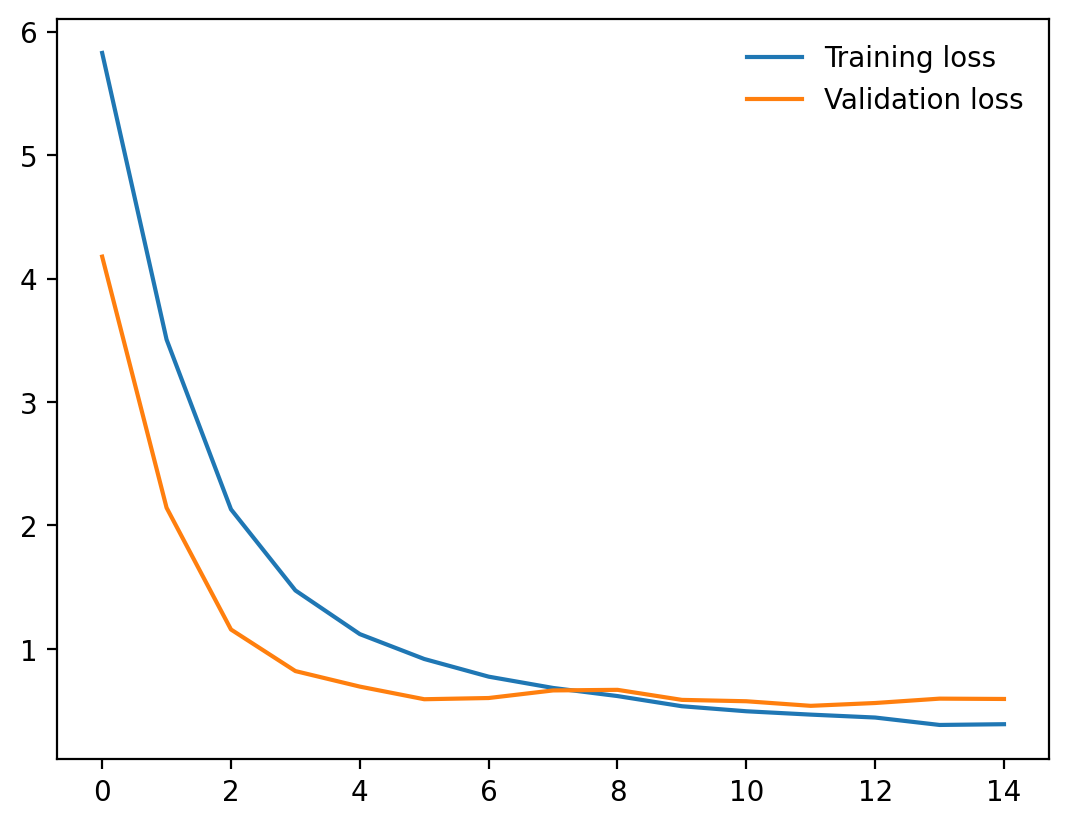

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

### Inference on Validation data

In [9]:
state_dict = torch.load('model_dna_seq.pth')
print(state_dict.keys())
model.load_state_dict(state_dict)

#prediction
accurate = 0
total = 0
for data,target in valid_loader:
    output = model(data)
    _,predicted = torch.max(output.data, 1)
    # total labels
    total+= target.size(0)

    # Total correct predictions
    accurate+= (predicted == target).sum()
    accuracy_score = 100 * accurate/total

print('Accuracy: {}%'.format(round(float(accuracy_score), 2)))

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
Accuracy: 82.06%


### Inference on Test data

In [10]:
one_hot_encoded_X_test = clean_seq(test_features)
print("Total test data shape", one_hot_encoded_X_test.shape)

batch_size = 64
test_loader = DataLoader(Tensor(one_hot_encoded_X_test), batch_size=batch_size)

encoded_predict_labels = []
# prediction
for data in test_loader:
    output = model(data)
    _,predicted = torch.max(output.data, 1)
    encoded_predict_labels.extend(predicted)

decoded_predict_labels = decode_labels(encoded_predict_labels, le)
print("decoded_predict_labels:", decoded_predict_labels)

/var/folders/ff/s5szj71n2q7226k0_1j2sf0c0000gq/T/ipykernel_75636/1050594908.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  sequences = [seq.str.replace('[^ACGT]','N')]


Total test data shape (4243, 3250)
decoded_predict_labels: [ 715 1150  782 ...  777  950  329]
